In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Load Some Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

# Load Directory

In [7]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

In [8]:
def load_window_from_chunks(window_start, window_end, directory, dimension_inds=None):
    dt = directory.end_time.iloc[0]/directory.end_ind.iloc[0]
    window_start = int(window_start/dt)
    window_end = int(window_end/dt)
    
    start_time_bool = directory.start_ind <= window_start
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(directory) else len(directory) - 1
    end_time_bool = directory.end_ind > window_end
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(directory) - 1
    
    window_data = None
    
    pos_in_window = 0
    for row_ind in range(start_row, end_row + 1):
        row = directory.iloc[row_ind]
        chunk = pd.read_pickle(row.filepath)
        if dimension_inds is None:
            dimension_inds = np.arange(chunk.shape[1])
        if window_data is None:
            window_data = np.zeros((window_end - window_start, len(dimension_inds)))
                
        if row.start_ind <= window_start:
            start_in_chunk = window_start - row.start_ind
        else:
            start_in_chunk = 0

        if row.end_ind <= window_end:
            end_in_chunk = chunk.shape[0]
        else:
            end_in_chunk = window_end - row.start_ind

        window_data[pos_in_window:pos_in_window + end_in_chunk - start_in_chunk] = chunk[start_in_chunk:end_in_chunk, dimension_inds]
        pos_in_window += end_in_chunk - start_in_chunk
                
    return window_data

# Load Data

In [9]:
session_info['drugStart']

array([1155.19066667, 2955.19066667])

In [10]:
wake_t = 300
anesthesia_t = 3000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [11]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 20, directory, unit_indices)
wake_signal_unnormed = deepcopy(wake_signal)
wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 20, directory, unit_indices)
anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

# Nonnormality

In [14]:
def nonnormality(A, normalized=False, return_eigvals=False):
    fro_norm = np.linalg.norm(A)**2
    eigvals = np.linalg.eigvals(A)
    eigval_sum = (np.abs(eigvals)**2).sum()
    if normalized:
        scale = 1/np.sqrt(A.shape[0])
    else:
        scale = 1
    nonnormality = np.sqrt(fro_norm - eigval_sum)*scale
    if return_eigvals:
        return nonnormality, eigvals
    else:
        return nonnormality

In [15]:
matrix_size = 6400

In [16]:
delase = DeLASE(wake_signal[:15000], p=int(matrix_size/wake_signal.shape[1]), dt=dt, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=0, lamb=0)

In [17]:
n, eigvals = nonnormality(delase.A.cpu(), return_eigvals=True)

In [18]:
n, n/matrix_size

(36924.74978170672, 5.769492153391675)

In [19]:
delase2 = deepcopy(delase)
delase2.compute_havok_dmd(r_thresh=0.3, lamb=0)

In [20]:
n2, eigvals2 = nonnormality(delase2.A.cpu(), return_eigvals=True)

n2, n2/matrix_size

(75.41207261399079, 0.01178313634593606)

In [21]:
delase2.r

tensor(4584, device='cuda:0')

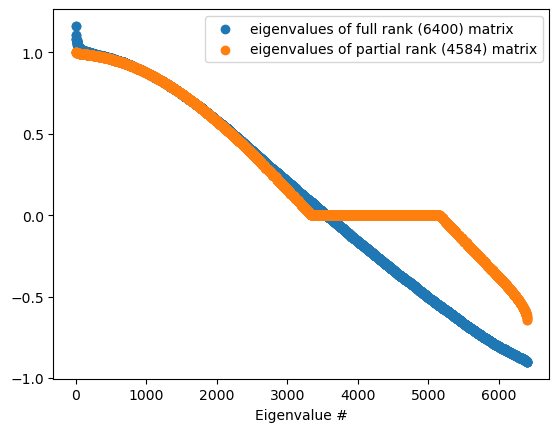

In [22]:
plt.scatter(np.arange(len(eigvals)), np.sort(np.real(eigvals))[::-1], label=f'eigenvalues of full rank ({delase.r}) matrix')
plt.scatter(np.arange(len(eigvals)), np.sort(np.real(eigvals2))[::-1], label=f'eigenvalues of partial rank ({delase2.r}) matrix')
plt.legend()
plt.xlabel('Eigenvalue #')
plt.show()

# DDE Algo

In [38]:
device = 'cpu'

In [31]:
delase.compute_jacobians()

In [49]:
Js = delase.Js.cpu()[:3]
N = 6
m = Js.shape[1] # system dimension
k = Js.shape[0] # num delays

In [40]:
tau = torch.arange(1, Js.shape[0] + 1).to(device)*dt

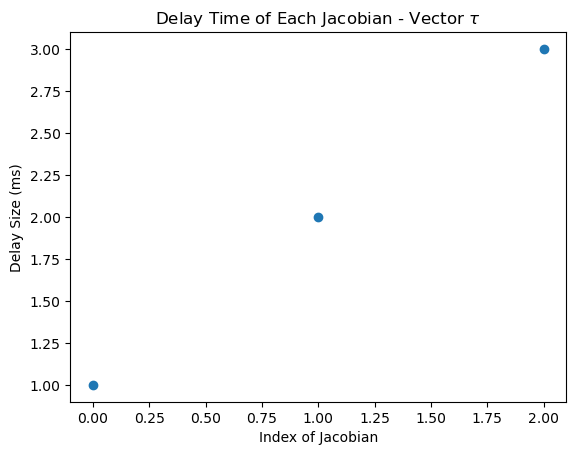

In [61]:
plt.scatter(np.arange(len(tau)), tau*1000)
plt.xlabel(r'Index of Jacobian')
plt.ylabel('Delay Size (ms)')
plt.title(r'Delay Time of Each Jacobian - Vector $\tau$')
plt.show()

In [50]:
L0 = torch.zeros(Js[0].shape).to(device)
T = float(torch.max(tau))
AN = torch.zeros(m*(N+1), m*(N+1)).to(device)

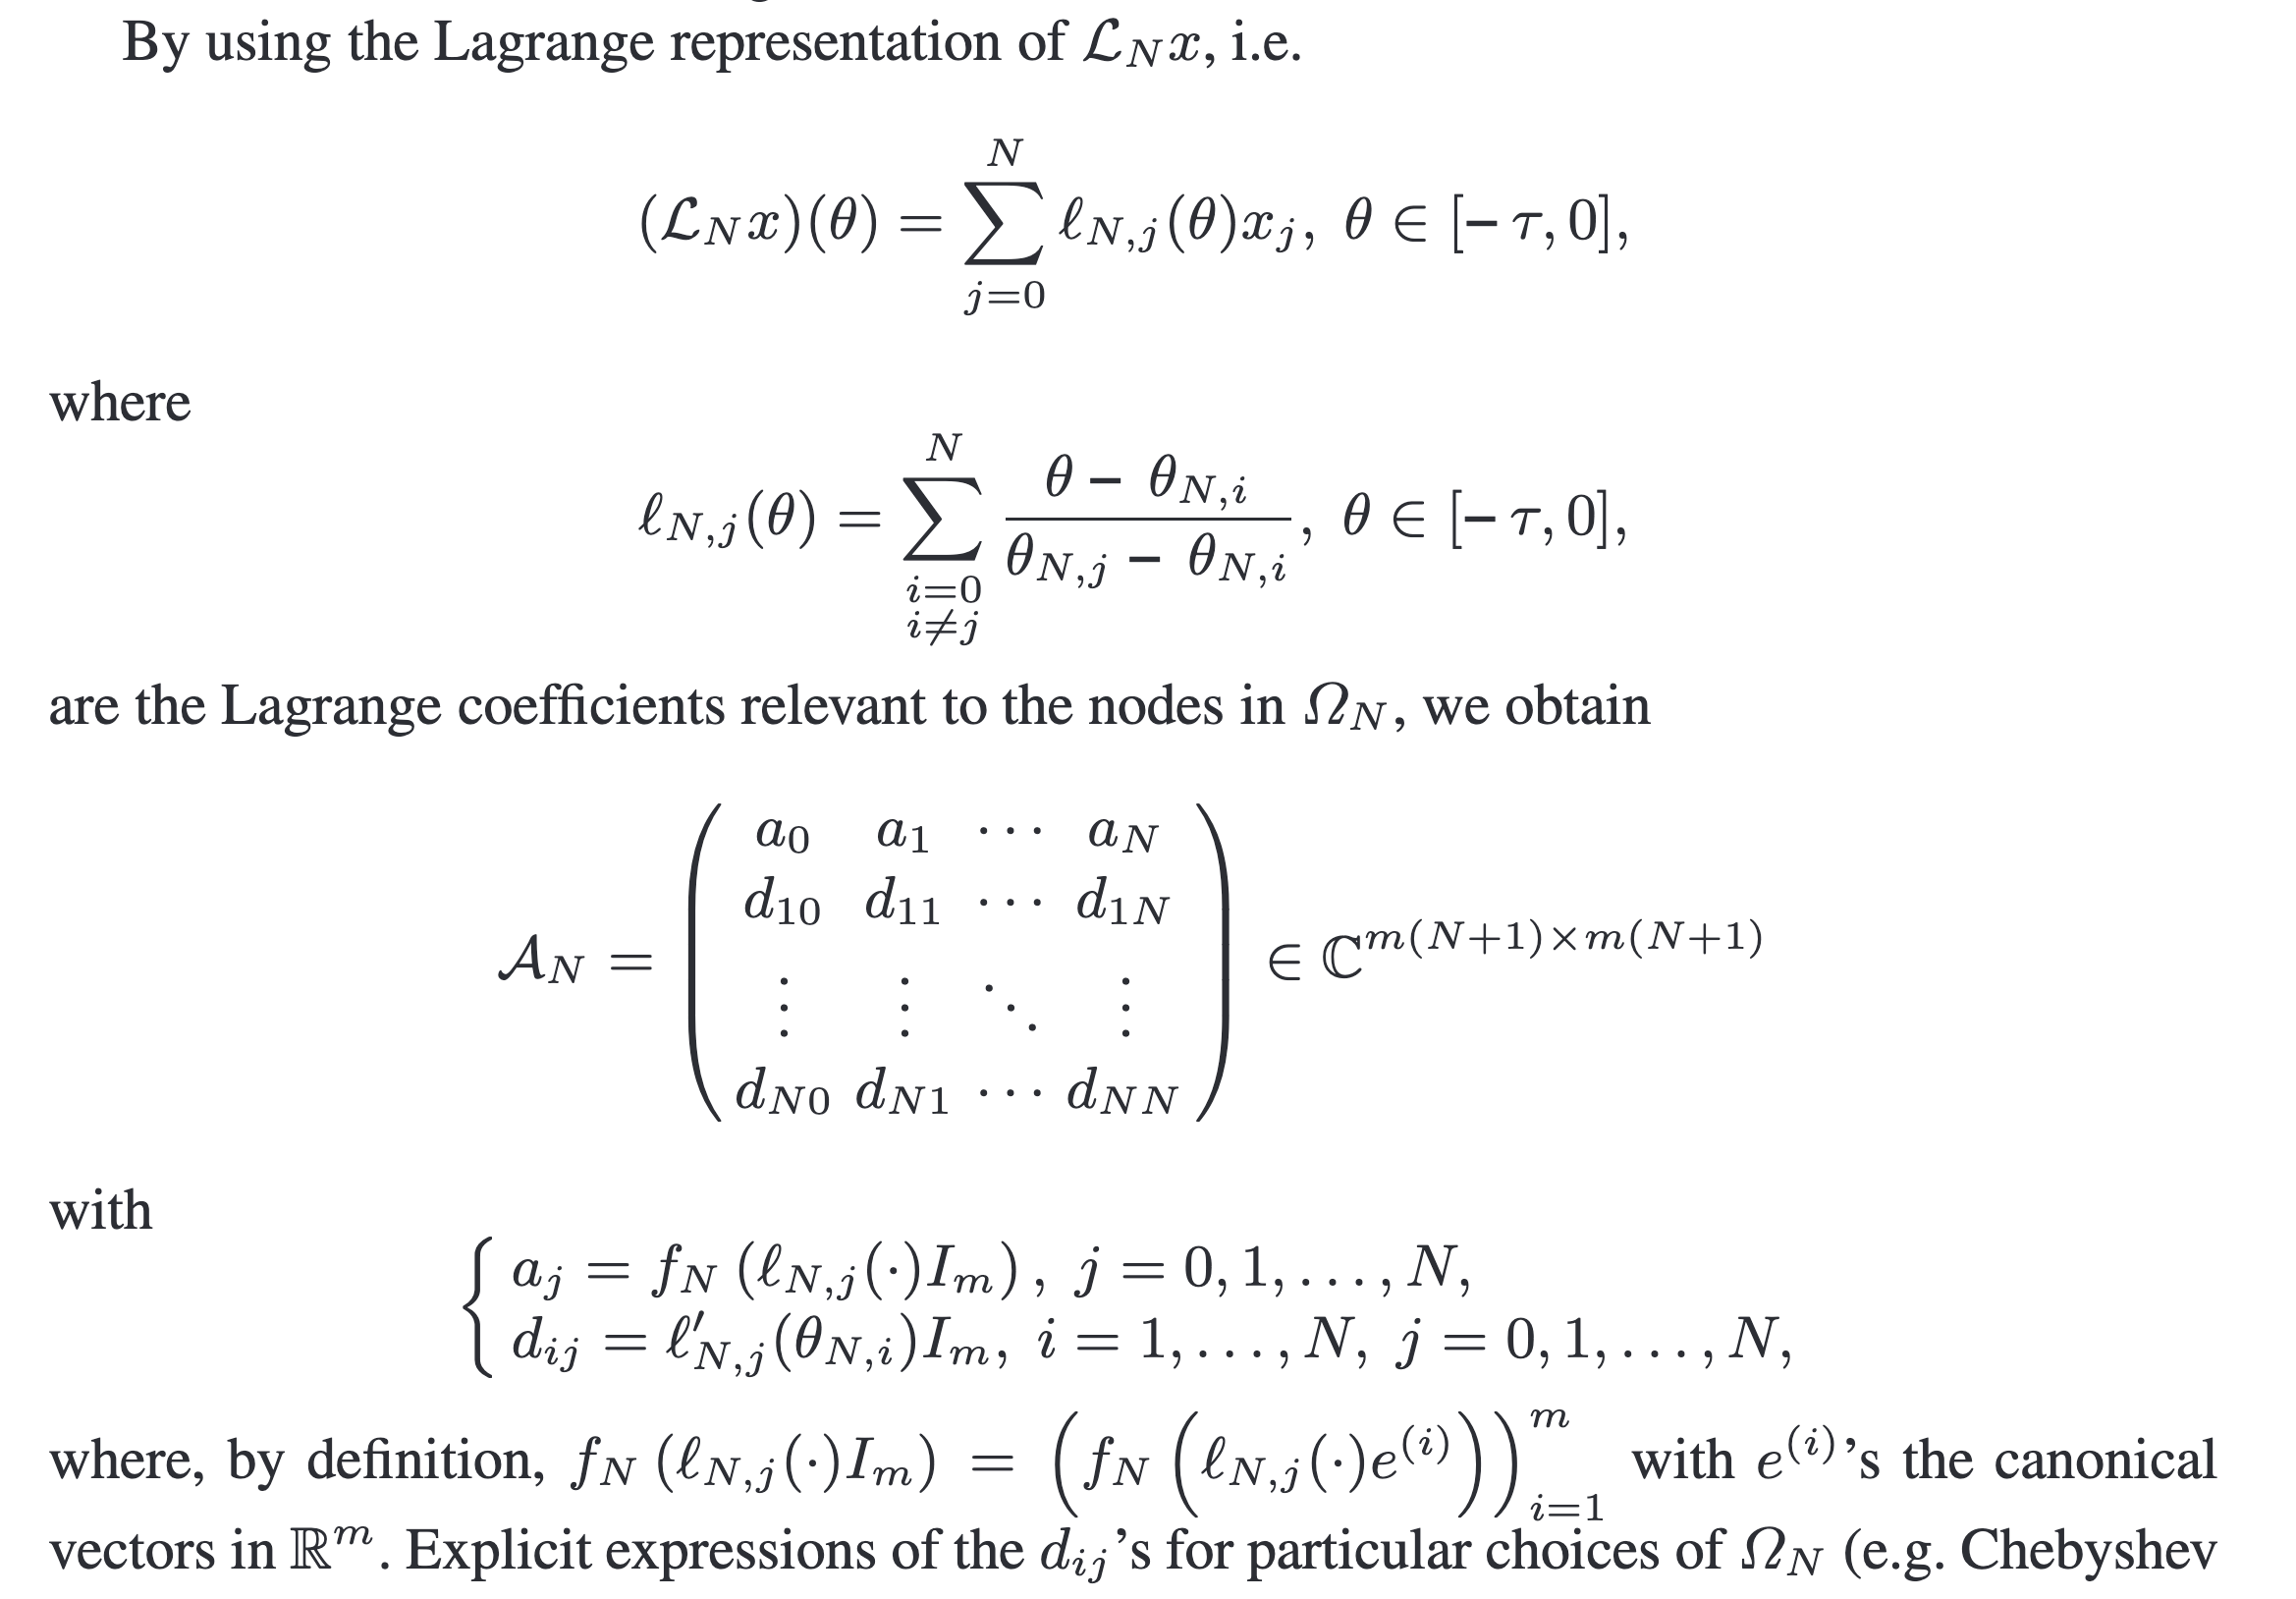

In [66]:
D, xx = cheb(N, T)

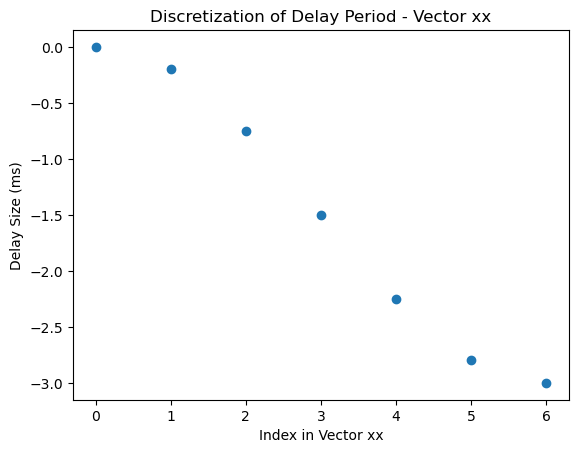

In [67]:
plt.scatter(np.arange(len(xx)), xx*1000)
plt.title('Discretization of Delay Period - Vector xx')
plt.xlabel('Index in Vector xx')
plt.ylabel('Delay Size (ms)')
plt.show()

We have that $\ell_{N, j}(\theta) = \sum_{i = 0 \\ i \neq j} \frac{\theta - \theta_{N, i}}{\theta_{N, j} - \theta_{N, i}}$ where $\theta_{N, i}$ is the $i^{th}$ point in the $N$-point discretization of the delay interval $[-\tau, 0]$. Thus,



$$\ell'_{N, j}(\theta) = \sum_{i = 0 \\ i \neq j} \frac{1}{\theta_{N, j} - \theta_{N, i}}$$

In [63]:
c = np.multiply(np.hstack([2, np.ones(N - 1), 2]), np.power(-1, np.arange(N + 1)))

In [69]:
np.outer(c, 1/c)

array([[ 1. , -2. ,  2. , -2. ,  2. , -2. ,  1. ],
       [-0.5,  1. , -1. ,  1. , -1. ,  1. , -0.5],
       [ 0.5, -1. ,  1. , -1. ,  1. , -1. ,  0.5],
       [-0.5,  1. , -1. ,  1. , -1. ,  1. , -0.5],
       [ 0.5, -1. ,  1. , -1. ,  1. , -1. ,  0.5],
       [-0.5,  1. , -1. ,  1. , -1. ,  1. , -0.5],
       [ 1. , -2. ,  2. , -2. ,  2. , -2. ,  1. ]])

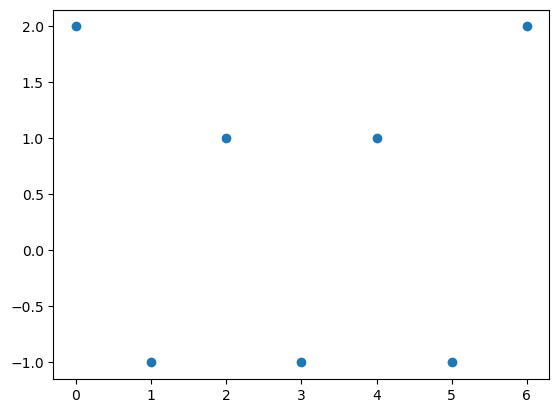

In [64]:
plt.scatter(np.arange(len(c)), c)

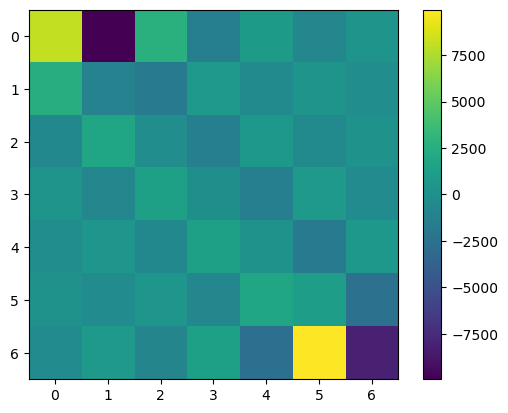

In [56]:
plt.imshow(D)
plt.colorbar()
plt.show()

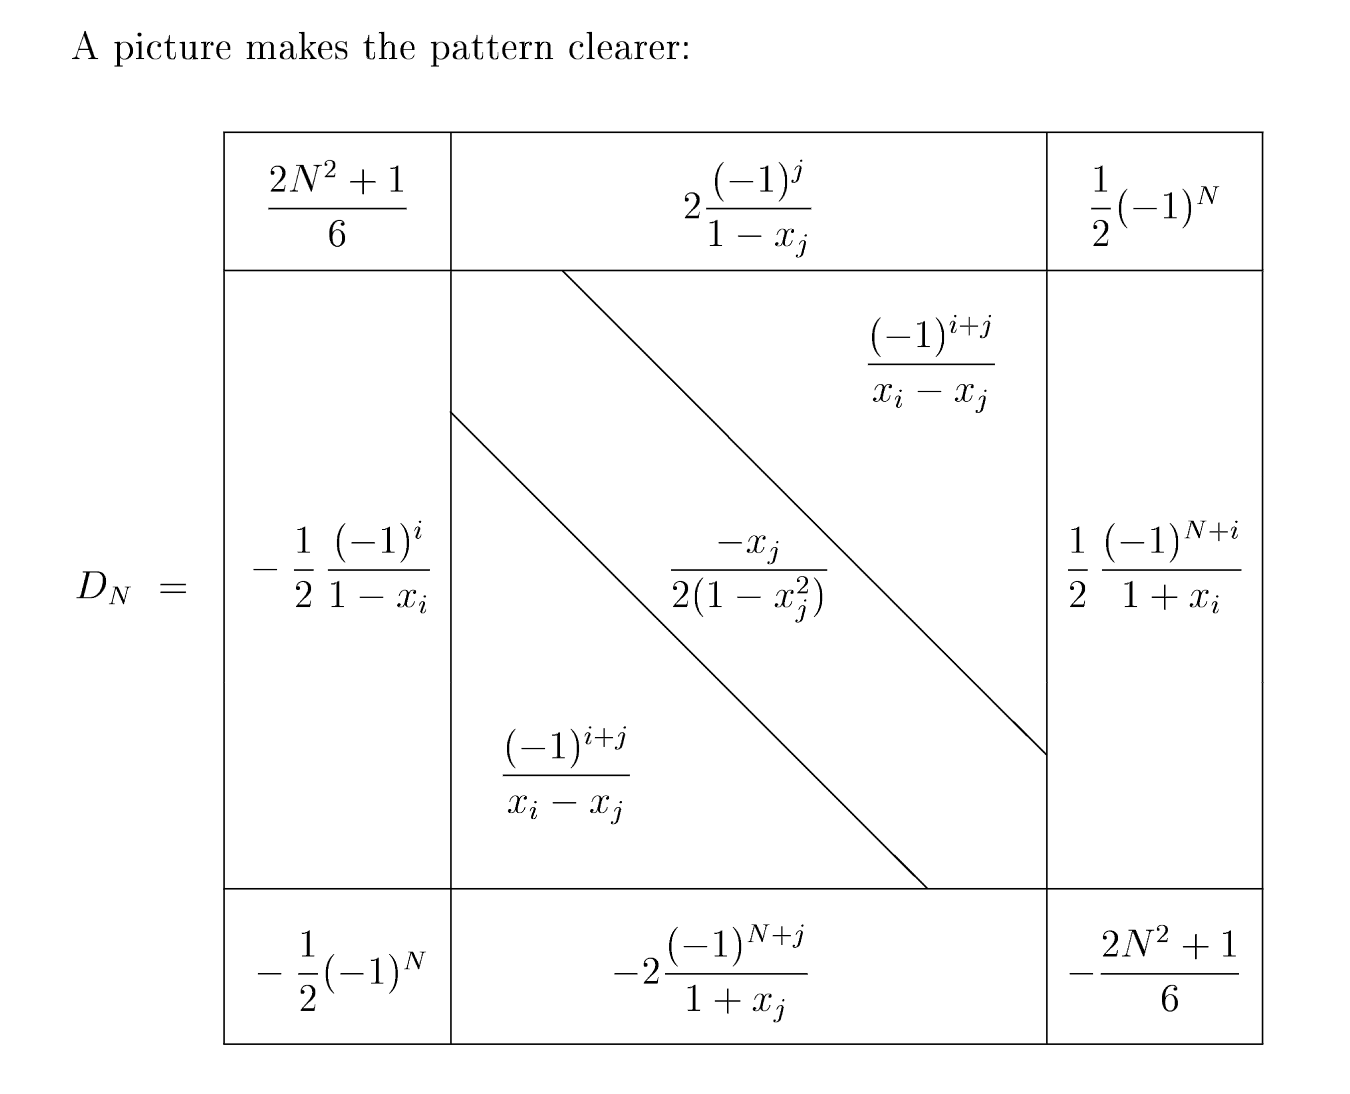

Okay I kind of think maybe the l's should be summed?

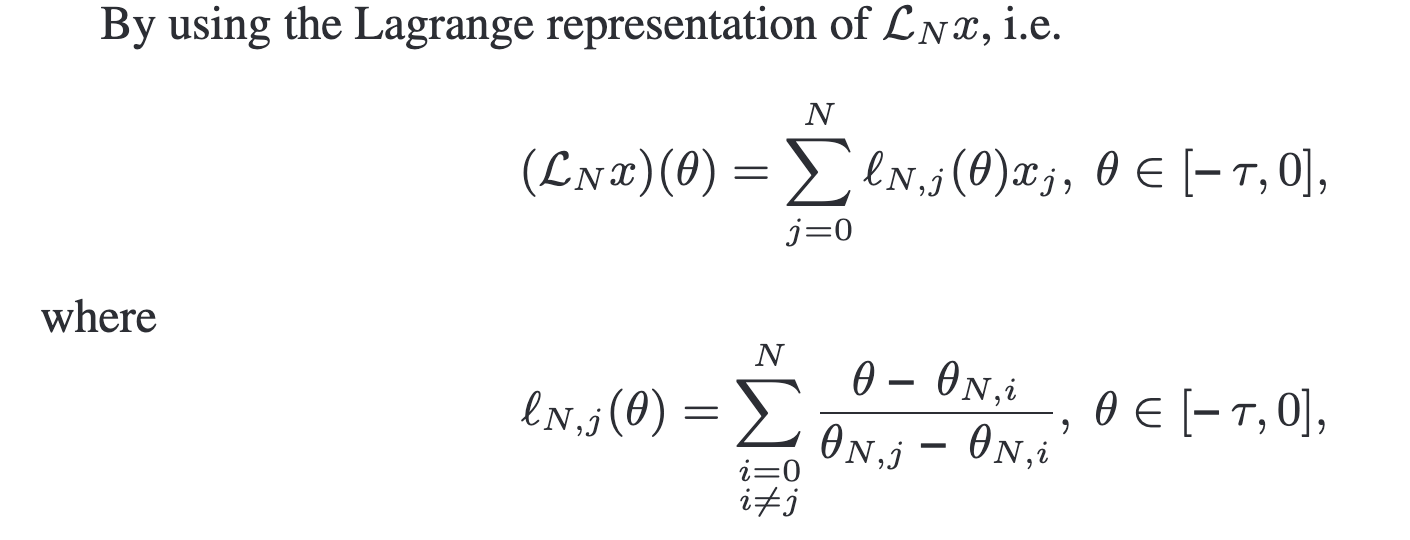

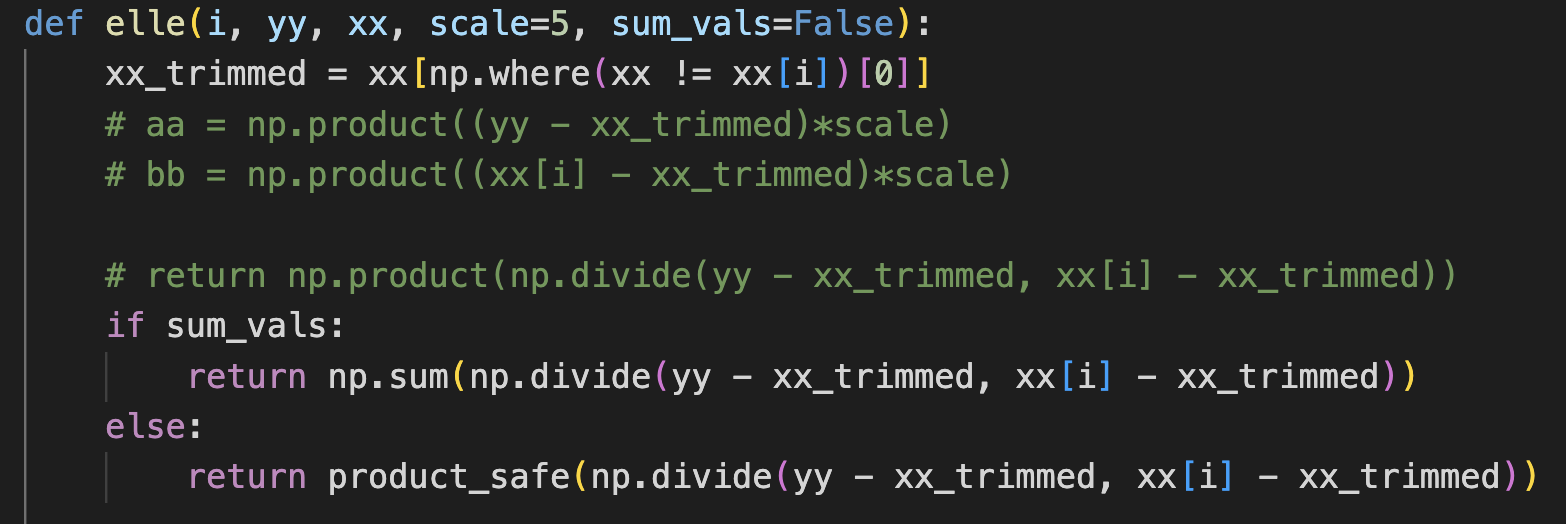

In [ ]:
delase.compute_jacobians()
delase2.compute_jacobians()

In [ ]:
delase.get_stability(sum_vals=True)

In [ ]:
summed_params = delase.stability_params.cpu()

In [ ]:
delase.get_stability(sum_vals=False)
prod_params = delase.stability_params.cpu()

In [ ]:
plt.plot(summed_params[:600])
plt.plot(prod_params[:600])

In [36]:
delase.get_stability(sum_vals=True, max_freq=500, max_unstable_freq=125)

In [49]:
delase.A - delase2.A

tensor([[ 2.5911e+00, -1.8023e-02,  6.4112e-02,  ..., -2.5649e-02,
          3.1320e-02, -1.5638e-02],
        [-4.0377e-02,  2.6418e+00,  5.9429e-02,  ..., -2.3079e-02,
          7.1671e-02, -9.9340e-03],
        [ 8.8607e-03, -2.2464e-02,  2.7618e+00,  ...,  1.9844e-02,
         -3.0445e-02,  1.7816e-02],
        ...,
        [ 1.7014e-04,  7.9080e-05, -9.6905e-04,  ..., -1.6696e-02,
          9.2010e-04,  2.1530e-03],
        [-1.1081e-04, -3.1963e-04, -2.7474e-05,  ...,  1.2111e-03,
         -1.3102e-02,  4.2235e-03],
        [ 1.2721e-04, -4.7855e-04,  8.6159e-05,  ...,  2.0559e-03,
          3.8823e-03, -1.6156e-02]], device='cuda:0')

In [37]:
summed_params = delase.stability_params.cpu()

In [38]:
delase.get_stability(sum_vals=False, max_freq=500, max_unstable_freq=125)
prod_params = delase.stability_params.cpu()

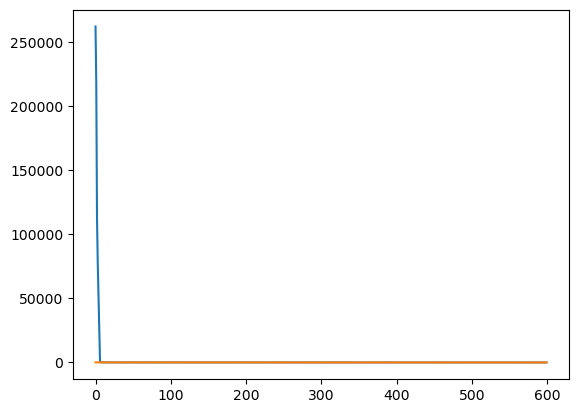

In [39]:
plt.plot(summed_params[:600])
plt.plot(prod_params[:600])

guess no

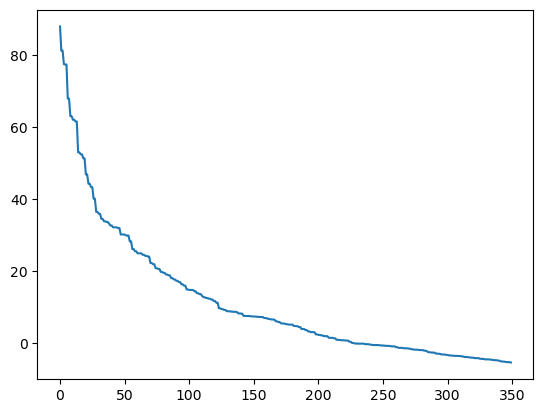

In [47]:
plt.plot(prod_params[:350])

# Testing Prediction and Decompositions

In [59]:
U_basis_coords = (delase.U.T @ delase.H.T).T
eigen_delay_coords = (delase.S_mat_inv @ delase.U.T @ delase.H.T).T

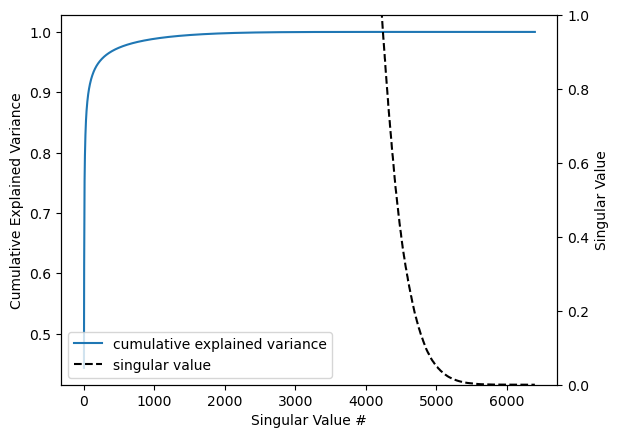

In [87]:
lns = []
lns += plt.plot(np.cumsum(((delase.S**2)/(((delase.S)**2).sum())).cpu()), label='cumulative explained variance')
plt.xlabel('Singular Value #')
plt.ylabel('Cumulative Explained Variance')
ax2 = plt.gca().twinx()
lns += ax2.plot(delase.S.cpu(), linestyle='--', c='k', label='singular value')
ax2.set_ylim([0, 1])
ax2.set_ylabel('Singular Value')
plt.legend(lns, [ln.get_label() for ln in lns], loc='lower left')
plt.show()

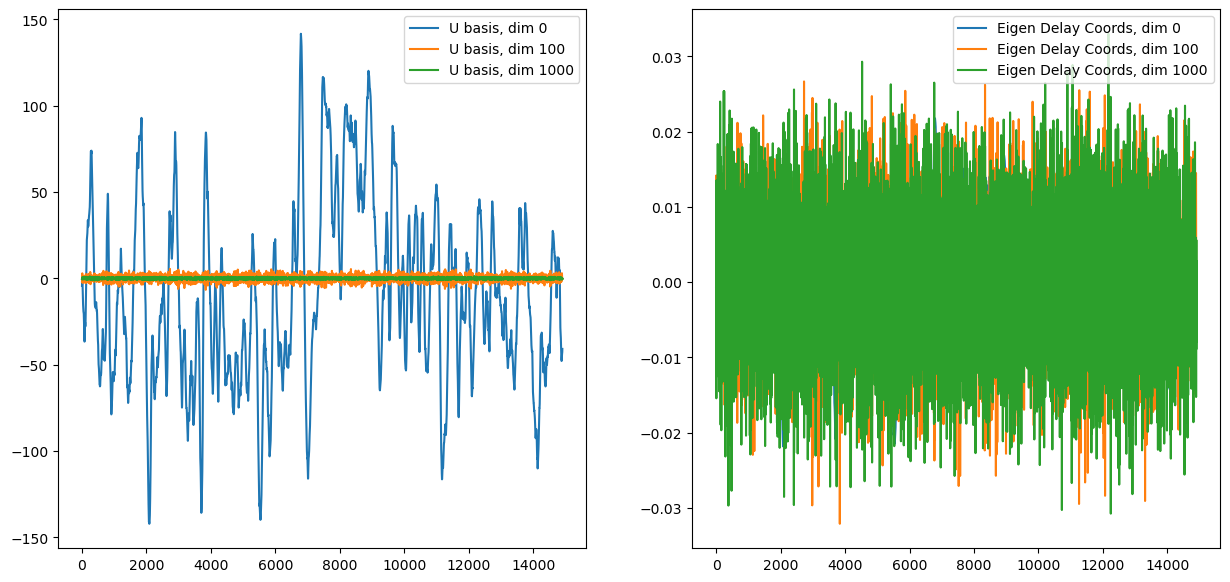

In [67]:
plt.figure(figsize=(15, 7))
dims = [0, 100, 1000]
plt.subplot(1, 2, 1)
for dim in dims:
    plt.plot(U_basis_coords[:, dim].cpu(), label=f'U basis, dim {dim}')
plt.legend()
plt.subplot(1, 2, 2)

for dim in dims:
    plt.plot(eigen_delay_coords[:, dim].cpu(), label=f'Eigen Delay Coords, dim {dim}')
plt.legend()
plt.show()

In [78]:
delase_preds = (delase.A @ delase.H[:-1].T).T
delase_preds2 = (delase2.A @ delase.H[:-1].T).T

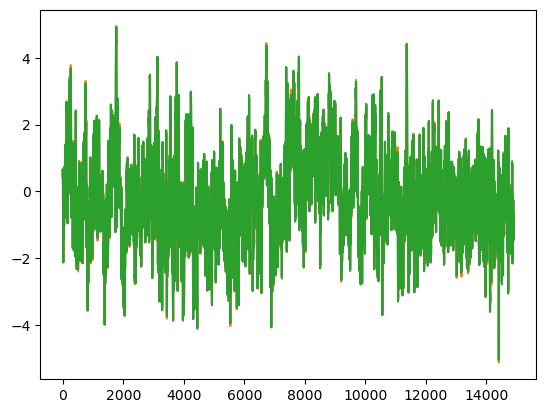

In [80]:
plt.plot(delase.H[1:, 0].cpu())
plt.plot(delase_preds[:, 0].cpu())
plt.plot(delase_preds2[:, 0].cpu())
plt.show()

In [89]:
delase_preds = delase.predict_havok_dmd(wake_signal[15000:], tail_bite=True, use_real_coords=True, reseed=50)
delase_preds2 = delase2.predict_havok_dmd(wake_signal[15000:], tail_bite=True, use_real_coords=True, reseed=50)

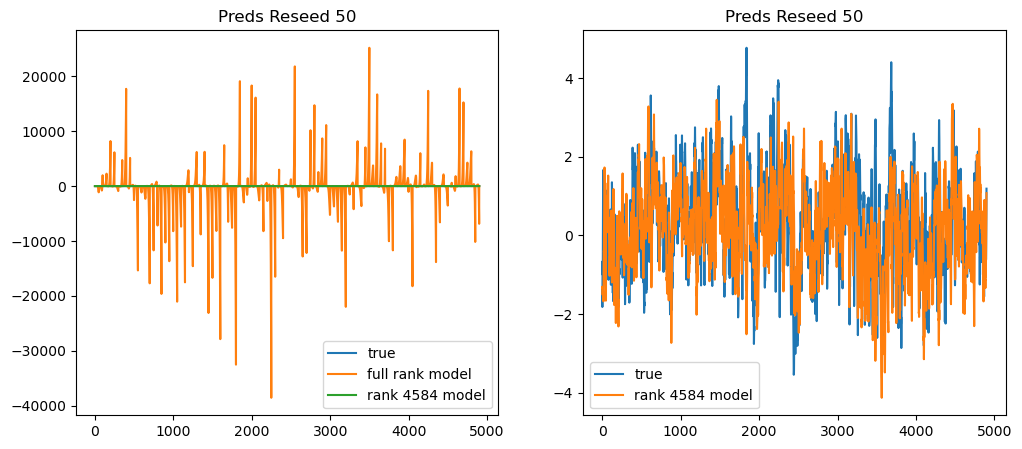

In [96]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Preds Reseed 50")
plt.plot(wake_signal[15000 + delase.p:, 0], label='true')
plt.plot(delase_preds[delase.p:, 0].cpu(), label='full rank model')
plt.plot(delase_preds2[delase2.p:, 0].cpu(), label=f'rank {delase2.r} model')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Preds Reseed 50")
plt.plot(wake_signal[15000 + delase.p:, 0], label='true')
plt.plot(delase_preds2[delase2.p:, 0].cpu(), label=f'rank {delase2.r} model')
plt.legend()
plt.show()

# Thing for Leo

In [9]:
wake_t = 300
anesthesia_t = 3000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [10]:
mins = 0.25
wake_signal_ = load_window_from_chunks(wake_t, wake_t + 60*mins, directory, unit_indices)

anesthesia_signal_ = load_window_from_chunks(anesthesia_t, anesthesia_t + 60*mins, directory,  unit_indices)

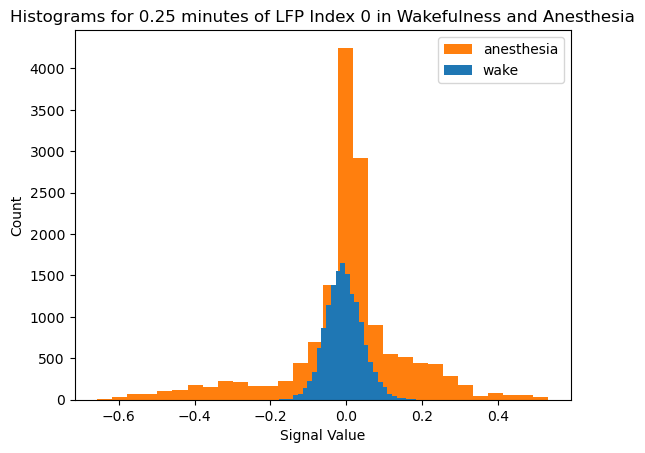

In [11]:
ind = 0
plt.title(f'Histograms for {mins} minutes of LFP Index {ind} in Wakefulness and Anesthesia')
plt.hist(anesthesia_signal_[:, 0], bins=30, label='anesthesia', color='C1')
plt.hist(wake_signal_[:, 0], bins=30, label='wake')
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.legend()
plt.show()

In [12]:
matrix_size = 6400

In [175]:
delase_wake = DeLASE(wake_signal_, p=int(matrix_size/wake_signal_.shape[1]), dt=dt, use_torch=True, device='cuda')
delase_wake.compute_havok_dmd(explained_variance=0.99, lamb=0, use_bias=True)

In [190]:
ip_ret = compute_integrated_performance(delase_wake, wake_signal_[:4000], verbose=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [191]:
delase_wake2 = DeLASE(wake_signal_, p=int(matrix_size/wake_signal_.shape[1]), dt=dt, use_torch=True, device='cuda')
delase_wake2.compute_havok_dmd(explained_variance=0.99, lamb=0)

ip_ret2 = compute_integrated_performance(delase_wake2, wake_signal_[:4000], verbose=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [202]:
def func(a):
    print(a)

In [205]:
string = 'a'

In [206]:
func(**{string: 1})

1


In [199]:
string = 'a'

In [201]:
dict(
    *string=1
)

SyntaxError: invalid syntax (1051222441.py, line 2)

In [197]:
def func(a):
    print(a)

[autoreload of parameter_choosing failed: Traceback (most recent call last):
  File "/om2/user/eisenaj/anaconda/envs/dynamical-trajectories/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/om2/user/eisenaj/anaconda/envs/dynamical-trajectories/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/om2/user/eisenaj/anaconda/envs/dynamical-trajectories/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 786, in exec_module
  File "<frozen importlib._bootstrap_external>", line 923, in get_code
  File "<frozen importlib._bootstrap_external>", line 853, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "../../DeLASE/parameter_choosin

In [ ]:
func(a=1)

In [14]:
delase_anesthesia = DeLASE(anesthesia_signal_, p=int(matrix_size/wake_signal_.shape[1]), dt=dt, use_torch=True, device='cuda')
delase_anesthesia.compute_havok_dmd(r_thresh=0.3, lamb=0)

In [15]:
wake_preds = delase_wake.predict_havok_dmd(wake_signal_, tail_bite=True, reseed=50, use_real_coords=True)
anesthesia_preds = delase_anesthesia.predict_havok_dmd(anesthesia_signal_, tail_bite=True, reseed=50, use_real_coords=True)

In [16]:
anesthesia_preds.cpu().numpy()[:, 0].shape

(15000,)

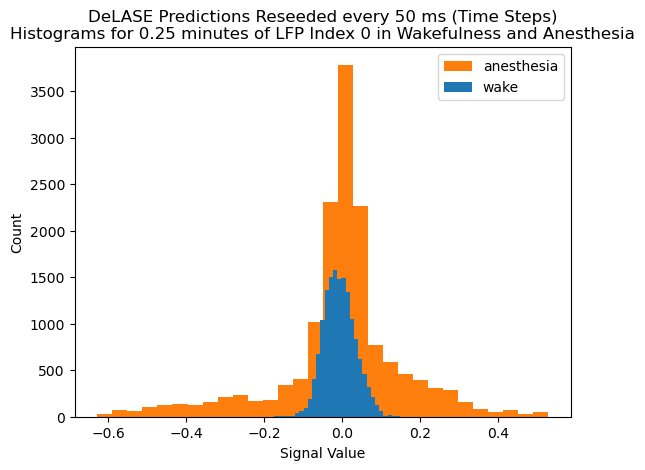

In [17]:
ind = 0
plt.title(f'DeLASE Predictions Reseeded every 50 ms (Time Steps)\nHistograms for {mins} minutes of LFP Index {ind} in Wakefulness and Anesthesia')
plt.hist(anesthesia_preds.cpu().numpy()[:, 0], bins=30, label='anesthesia', color='C1')
plt.hist(wake_preds.cpu().numpy()[:, 0], bins=30, label='wake')
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.legend()
plt.show()

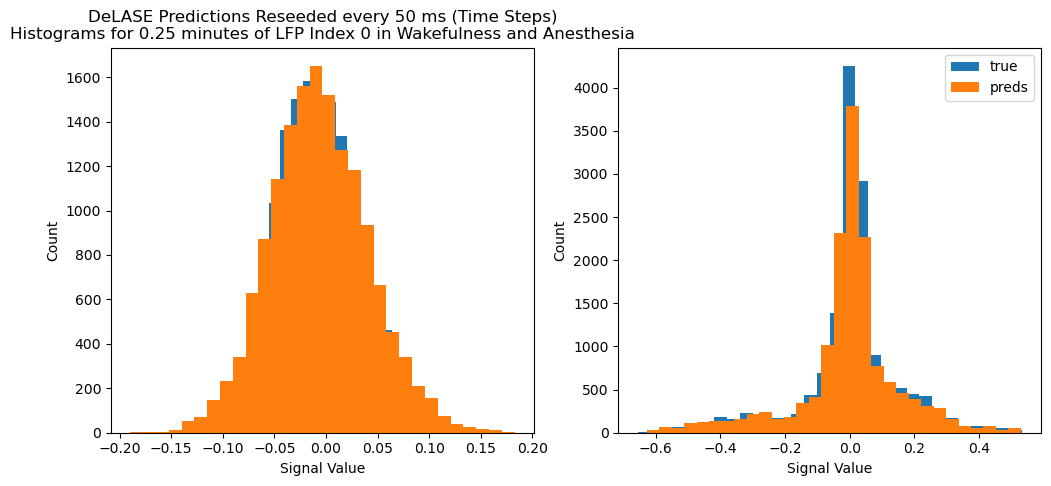

In [18]:
plt.figure(figsize=(12, 5))
ind = 0
plt.subplot(1, 2, 1)
plt.title(f'DeLASE Predictions Reseeded every 50 ms (Time Steps)\nHistograms for {mins} minutes of LFP Index {ind} in Wakefulness and Anesthesia')
plt.hist(wake_preds.cpu().numpy()[:, 0], bins=30, label='true')
plt.hist(wake_signal_[:, 0], bins=30, label='preds')
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.hist(anesthesia_signal_[:, 0], bins=30, label='true')
plt.hist(anesthesia_preds.cpu().numpy()[:, 0], bins=30, label='preds')

plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.legend()
plt.show()

In [21]:
d = calc_div_from_data(wake_signal_[:4000], wake_preds.cpu().numpy()[:4000], use_torch=True, device='cuda')

In [22]:
d

tensor(-0.0003, device='cuda:0')

In [23]:
wake_preds2 = delase_wake.predict_havok_dmd(wake_signal_, tail_bite=True, reseed=1000, use_real_coords=True)
anesthesia_preds2 = delase_anesthesia.predict_havok_dmd(anesthesia_signal_, tail_bite=True, reseed=1000, use_real_coords=True)

In [28]:
d = calc_div_from_data(wake_signal_[:4000], wake_preds2.cpu().numpy()[:4000], symmetric=True, use_torch=True, device='cuda')

In [29]:
d

tensor(0.6343, device='cuda:0')

In [ ]:
plt.figure(figsize=(12, 5))
ind = 0
plt.subplot(1, 2, 1)
plt.title(f'DeLASE Predictions Reseeded every 50 ms (Time Steps)\nHistograms for {mins} minutes of LFP Index {ind} in Wakefulness and Anesthesia')
plt.hist(wake_signal_[:, 0], bins=30, label='true')
plt.hist(wake_preds2.cpu().numpy()[:, 0], bins=30, label='prds')

plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.hist(anesthesia_signal_[:, 0], bins=30, label='true')
plt.hist(anesthesia_preds2.cpu().numpy()[:, 0], bins=30, label='preds')

plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.legend()
plt.show()

# Small Parameter Test

# Load Data

In [30]:
session_info['drugStart']

array([1155.19066667, 2955.19066667])

In [31]:
wake_t = 300
anesthesia_t = 3000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [32]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 20, directory, unit_indices)
wake_signal_unnormed = deepcopy(wake_signal)
wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 20, directory, unit_indices)
anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

# Parameter Search

In [33]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )

parameter_grid = ParameterGrid(
    window_vals=np.array([5000, 10000, 15000]),
    matrix_size_vals=np.array([1000, 2000, 3000, 4000, 5000, 6000, 8000]),
    r_thresh_vals=np.array([0.3]),
    lamb_vals=np.array([0]),
    reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
)

In [38]:
wake_ret = parameter_search(wake_signal[:15000], wake_signal[15000:], parameter_grid, dt=dt, use_torch=True, device='cuda', verbose=True)

  0%|          | 0/357 [00:00<?, ?it/s]

In [39]:
pd.to_pickle(wake_ret, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'wake_ret_mary_normed_windowsmatrices_{area}.pkl'))
# wake_ret = pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'wake_ret_mary_normed_{area}.pkl'))

In [40]:
anesthesia_ret = parameter_search(anesthesia_signal[:15000], anesthesia_signal[15000:], parameter_grid, dt=dt, use_torch=True, device='cuda', verbose=True)

  0%|          | 0/357 [00:00<?, ?it/s]

In [41]:
pd.to_pickle(anesthesia_ret, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'anesthesia_ret_mary_normed_windowsmatrices_{area}.pkl'))
# wake_ret = pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'wake_ret_mary_normed_{area}.pkl'))

# Plots

In [42]:
wake_ret.columns

Index(['window', 'p', 'r_thresh', 'lamb', 'ip', 'performance_curve',
       'reseed_vals', 'all_metric_vals', 'stability_params',
       'stability_freqs'],
      dtype='object')

In [59]:
window_vals = np.array([val if val < 1e-1 else float(val) for val in wake_ret.window.unique()])
p_vals = np.array([val if val < 1e-1 else float(val) for val in wake_ret.p.unique()])

wake_ip = np.zeros((len(p_vals), len(window_vals)))
anesthesia_ip = np.zeros((len(p_vals), len(window_vals)))
# anesthesia_ip = np.zeros((len(lamb_vals), len(r_thresh_vals)))

iterator = tqdm(total=len(window_vals)*len(p_vals))

for i, window in enumerate(window_vals):
    for j, p in enumerate(p_vals):
        rows = wake_ret[np.logical_and(wake_ret.window == window, wake_ret.p == p)]
        if len(rows) == 0:
            wake_ip[j, i] = np.nan
        else:
            wake_ip[j, i] = rows.ip
            if np.isnan(wake_ip[j, i]):
                wake_ip[j, i] = -1
            elif wake_ip[j, i] < -1:
                wake_ip[j, i] = -1
            
        rows = anesthesia_ret[np.logical_and(anesthesia_ret.window == window, anesthesia_ret.p == p)]
        if len(rows) == 0:
            anesthesia_ip[j, i] = np.nan
        else:
            anesthesia_ip[j, i] = rows.ip
            if np.isnan(anesthesia_ip[j, i]):
                anesthesia_ip[j, i] = -1
            elif anesthesia_ip[j, i] < -1:
                anesthesia_ip[j, i] = -1
                
        iterator.update()
iterator.close()
            
#         anesthesia_ip[j, i] = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].ip

  0%|          | 0/21 [00:00<?, ?it/s]

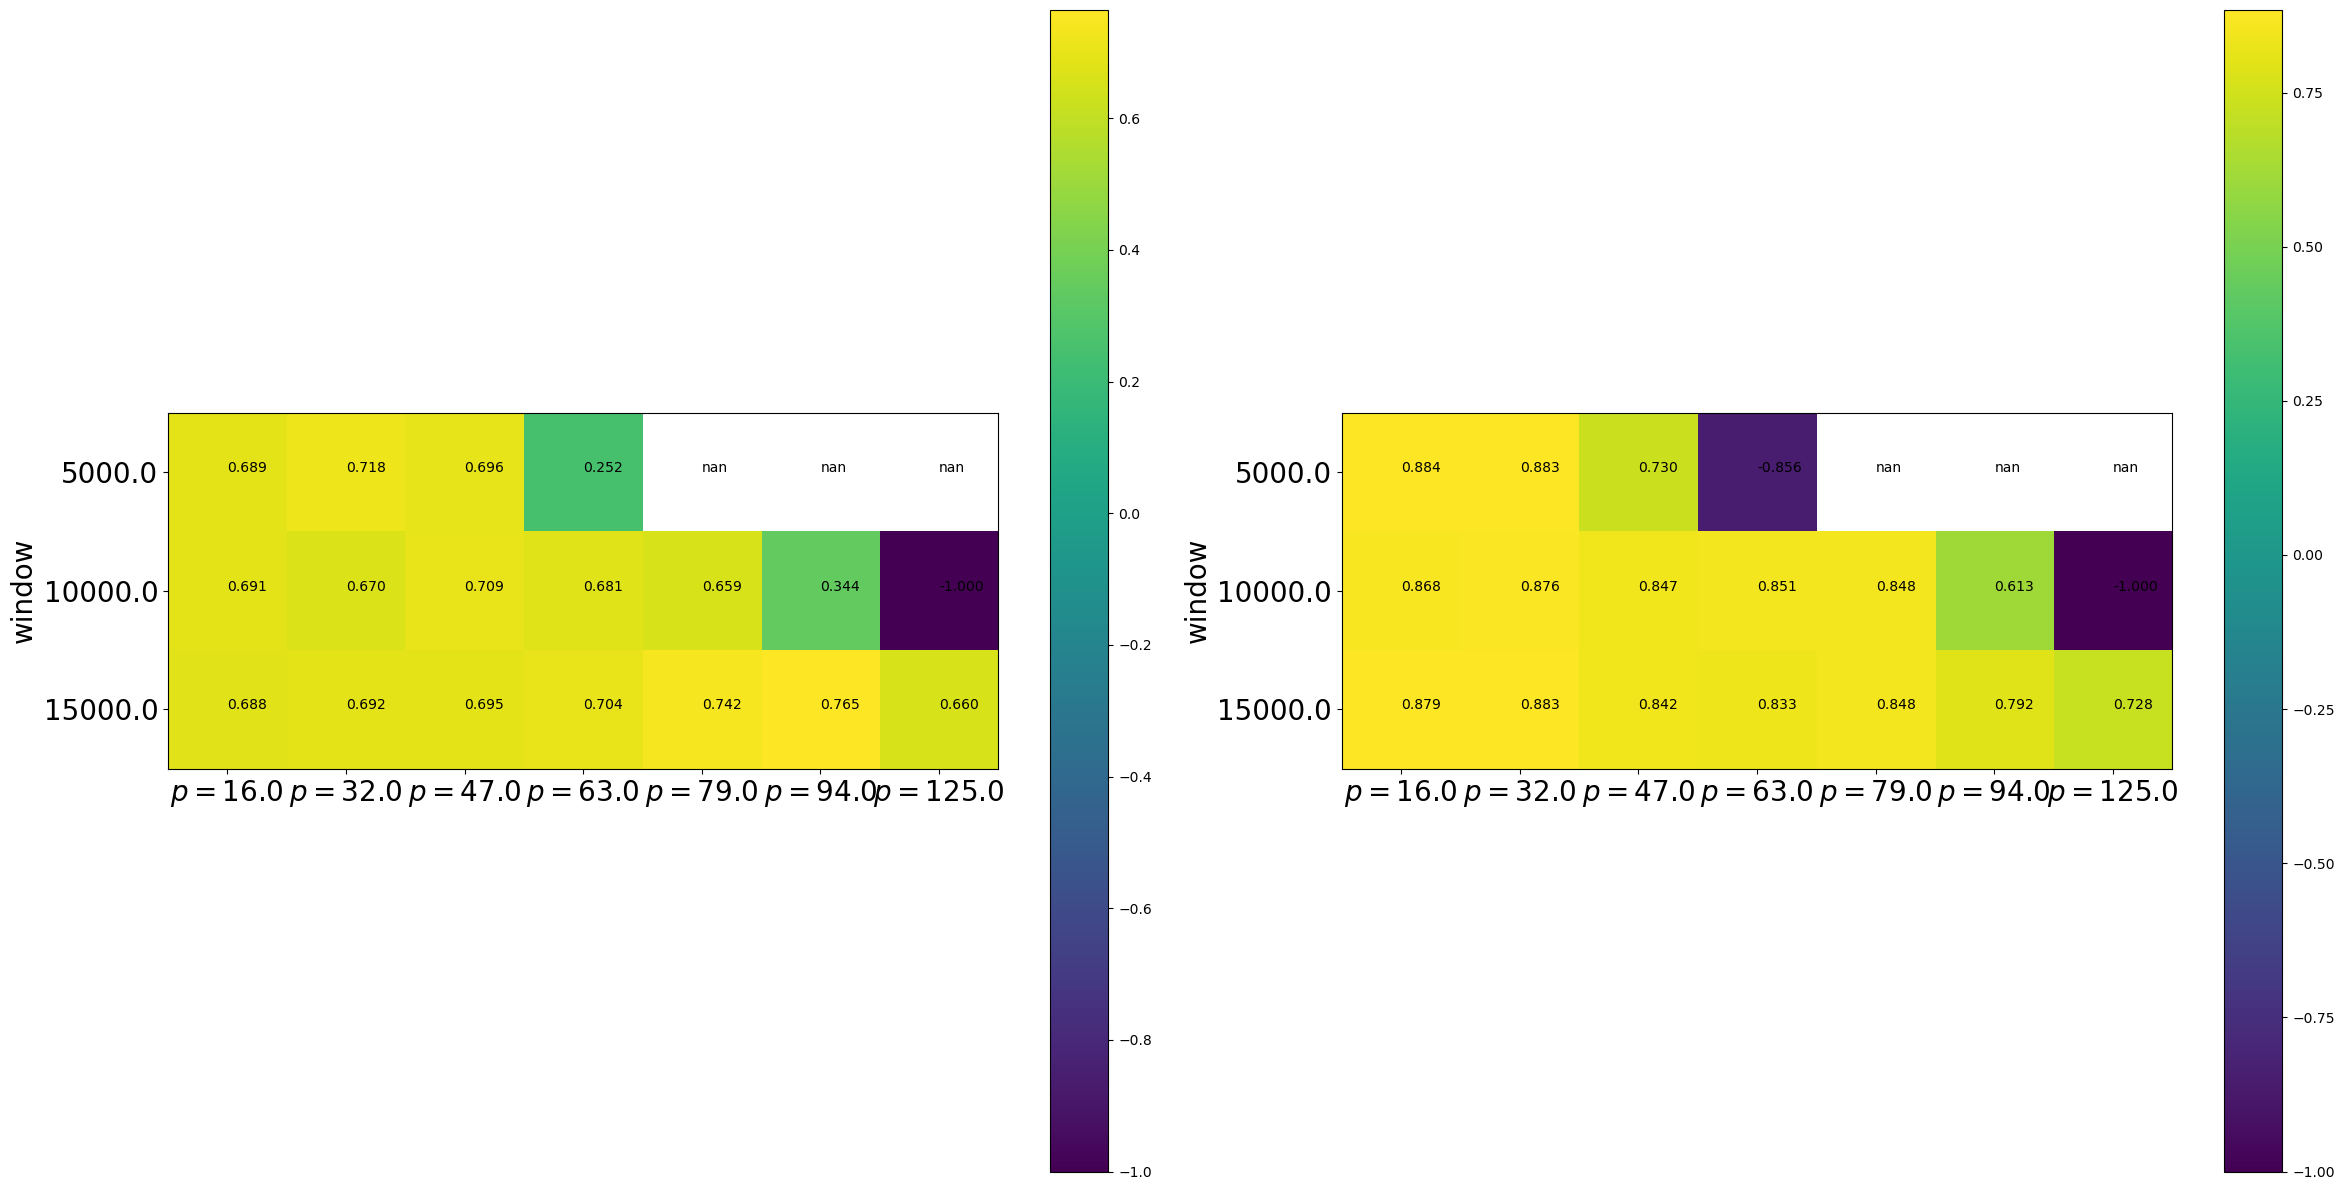

In [60]:
# min_r_thresh = 0.01
ip = wake_ip.T
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.imshow(ip)
plt.colorbar()
plt.yticks(np.arange(len(window_vals)), [f"{window}" for window in window_vals])
plt.ylabel("window", fontsize=20)
plt.xticks(np.arange(len(p_vals)), ["$p = $" + f"{p}" for p in p_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip.max()
for i in range(ip.shape[0]):
    for j in range(ip.shape[1]):
        if ip[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip[i, j]:.3f}", color=c)
 

ip = anesthesia_ip.T
plt.subplot(1, 2, 2)
plt.imshow(ip)
plt.colorbar()
plt.yticks(np.arange(len(window_vals)), [f"{window}" for window in window_vals])
plt.ylabel("window", fontsize=20)
plt.xticks(np.arange(len(p_vals)), ["$p = $" + f"{p}" for p in p_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip.max()
for i in range(ip.shape[0]):
    for j in range(ip.shape[1]):
        if ip[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip[i, j]:.3f}", color=c)
plt.tight_layout()
plt.show()

In [73]:
ip[~np.isnan(ip)].max()

0.8004575896561146

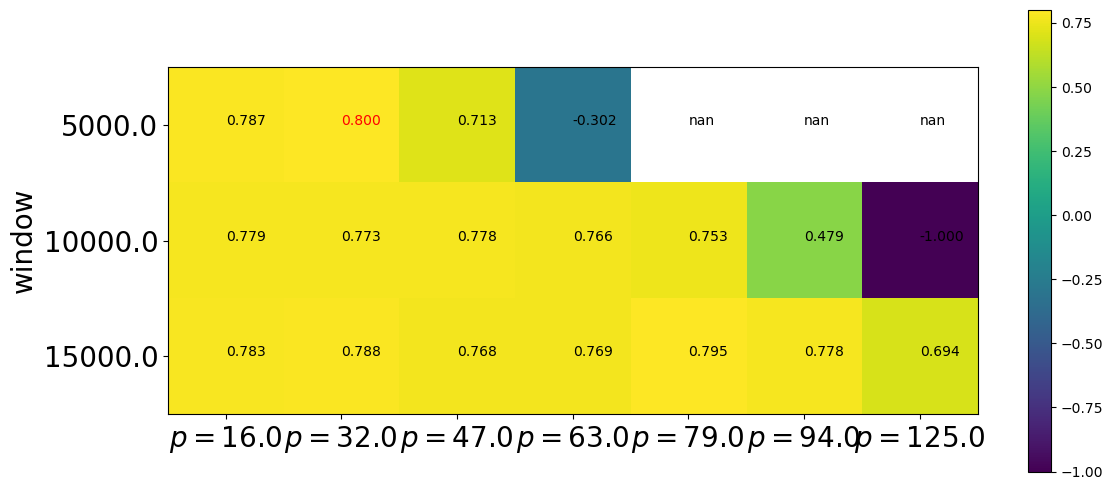

In [74]:
ip = (wake_ip.T + anesthesia_ip.T)/2
plt.figure(figsize=(12, 5))
plt.imshow(ip)
plt.colorbar()
plt.yticks(np.arange(len(window_vals)), [f"{window}" for window in window_vals])
plt.ylabel("window", fontsize=20)
plt.xticks(np.arange(len(p_vals)), ["$p = $" + f"{p}" for p in p_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip[~np.isnan(ip)].max()
for i in range(ip.shape[0]):
    for j in range(ip.shape[1]):
        if ip[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip[i, j]:.3f}", color=c)
plt.tight_layout()
plt.show()

# Stability

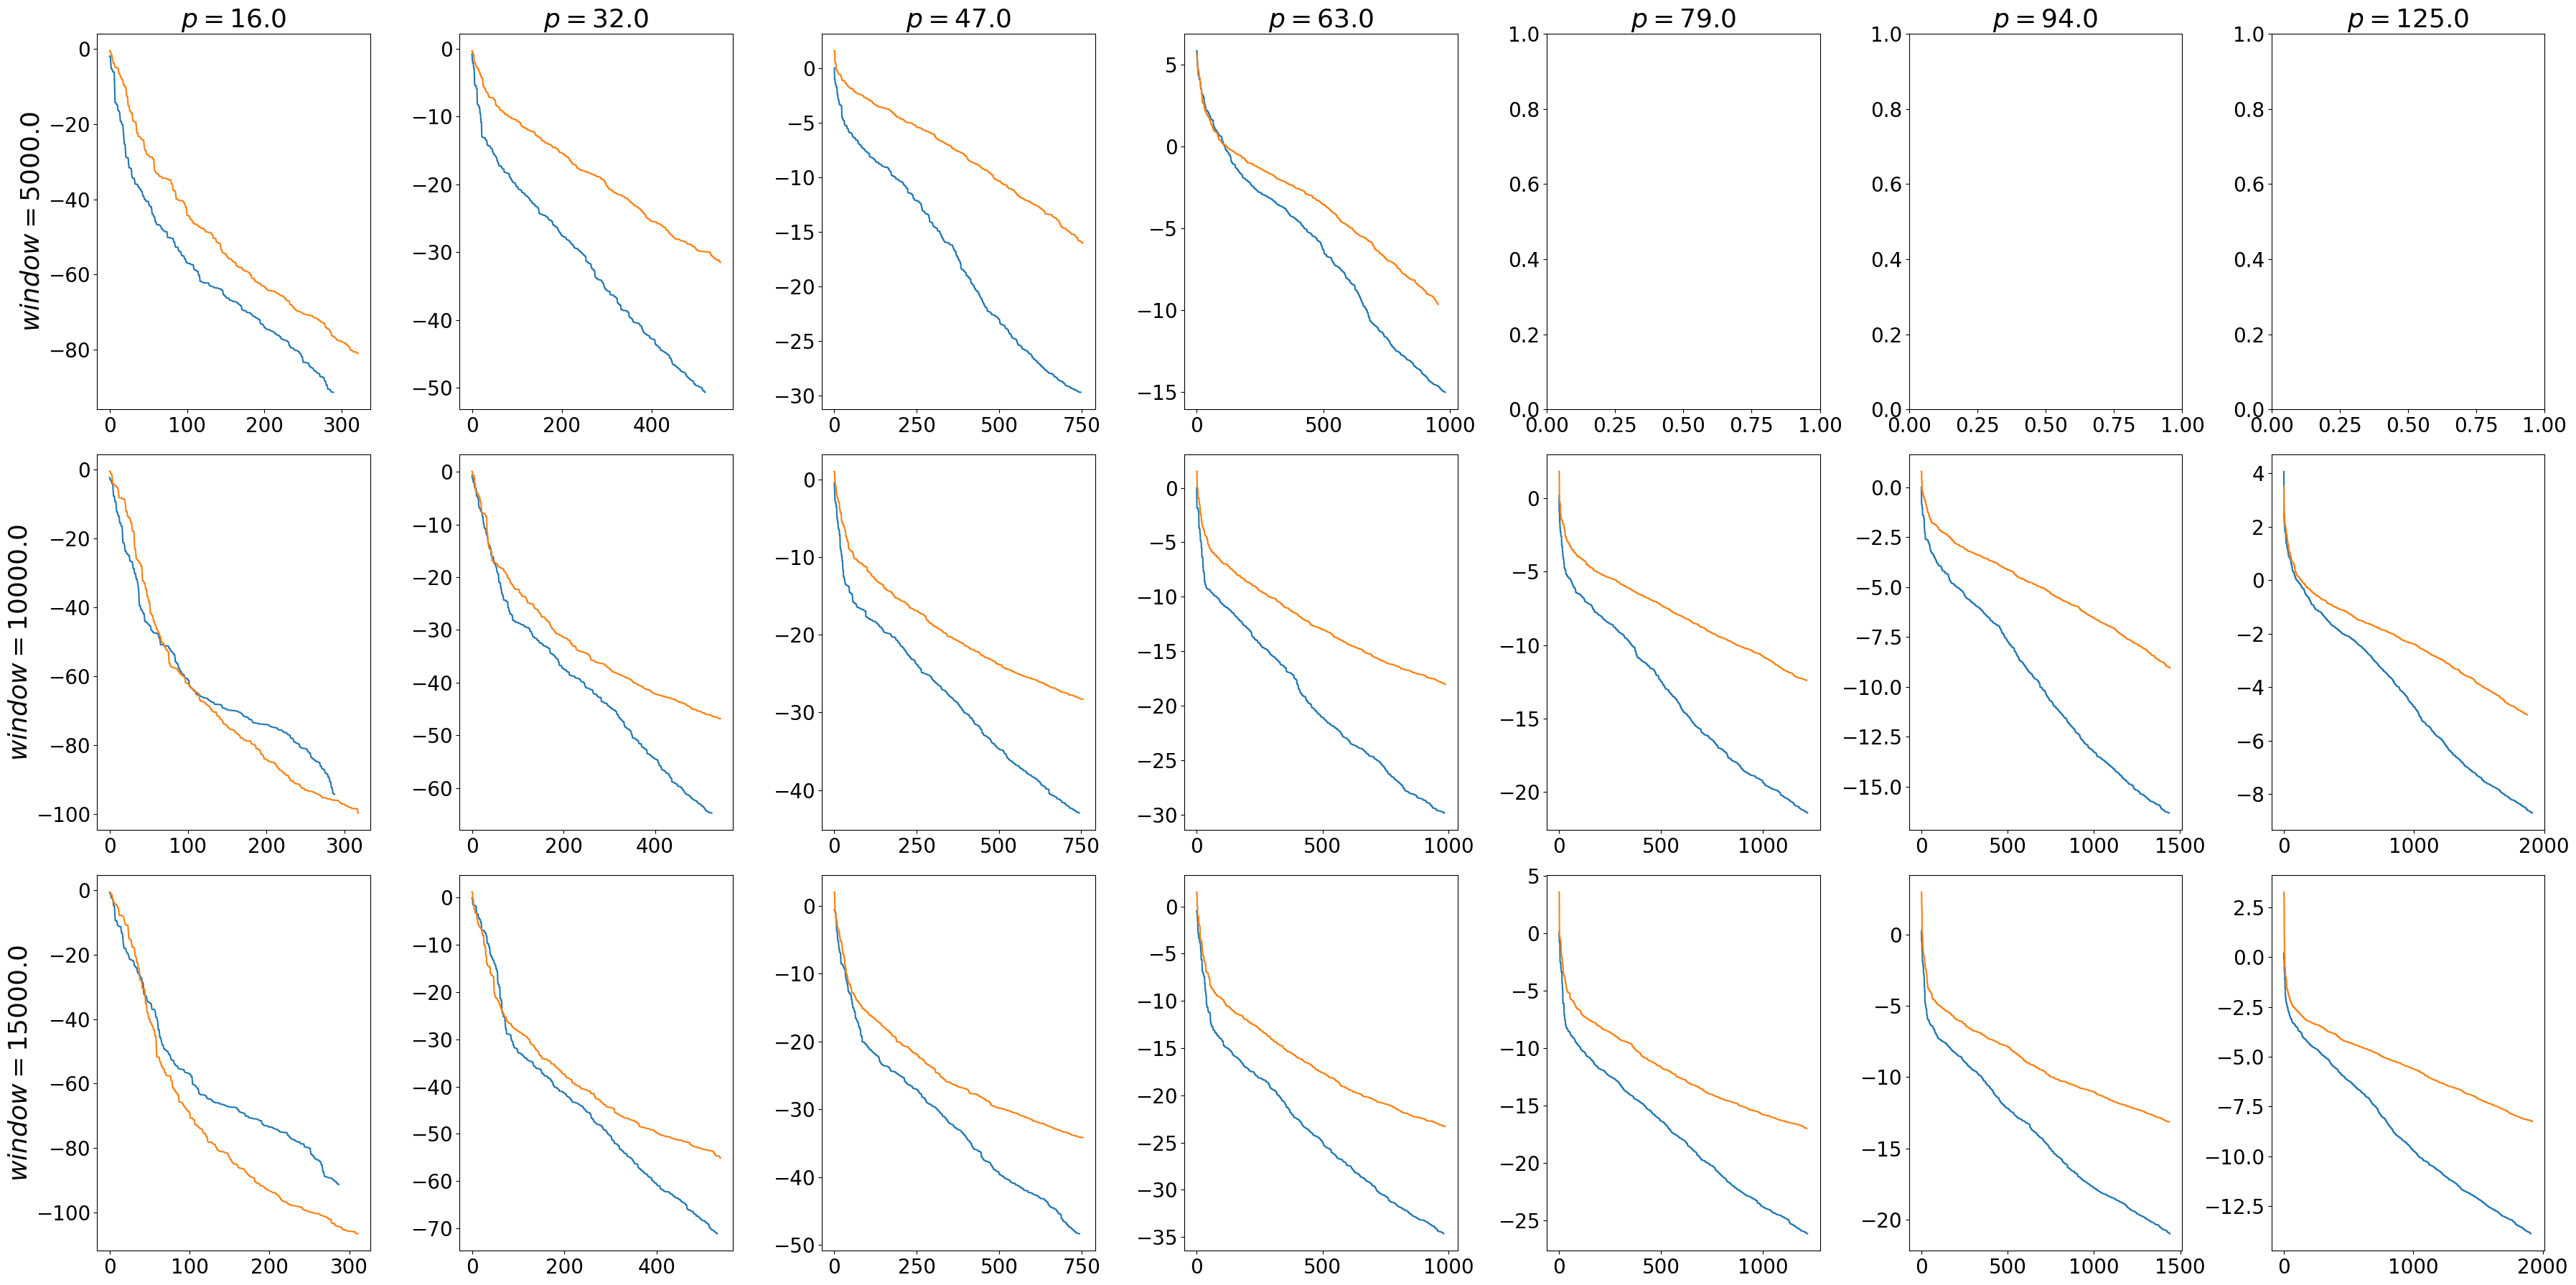

In [101]:
top_percent = 0.3

fig, axs = plt.subplots(len(window_vals), len(p_vals), figsize=(36, 18))
for i, window in enumerate(window_vals):
    for j, p in enumerate(p_vals):
        rows = wake_ret[np.logical_and(wake_ret.window == window, wake_ret.p == p)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()
        ax = axs[i, j]
        if len(rows) >0:
            wake_curve = rows[0]
            anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.window==window, anesthesia_ret.p == p)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
            ax.plot(wake_curve)
            ax.plot(anesthesia_curve)
    #         ax2.plot([lyaps[key][:1].mean() for key in keys], linestyle='--', c='C1')
        if j == 0:
            ax.set_ylabel(f"$window = ${window}", fontsize=26)
        if i == 0:
            ax.set_title("$p = $" + f"{p}", fontsize=26)
        ax.tick_params(labelsize=20)
plt.tight_layout()
plt.show()

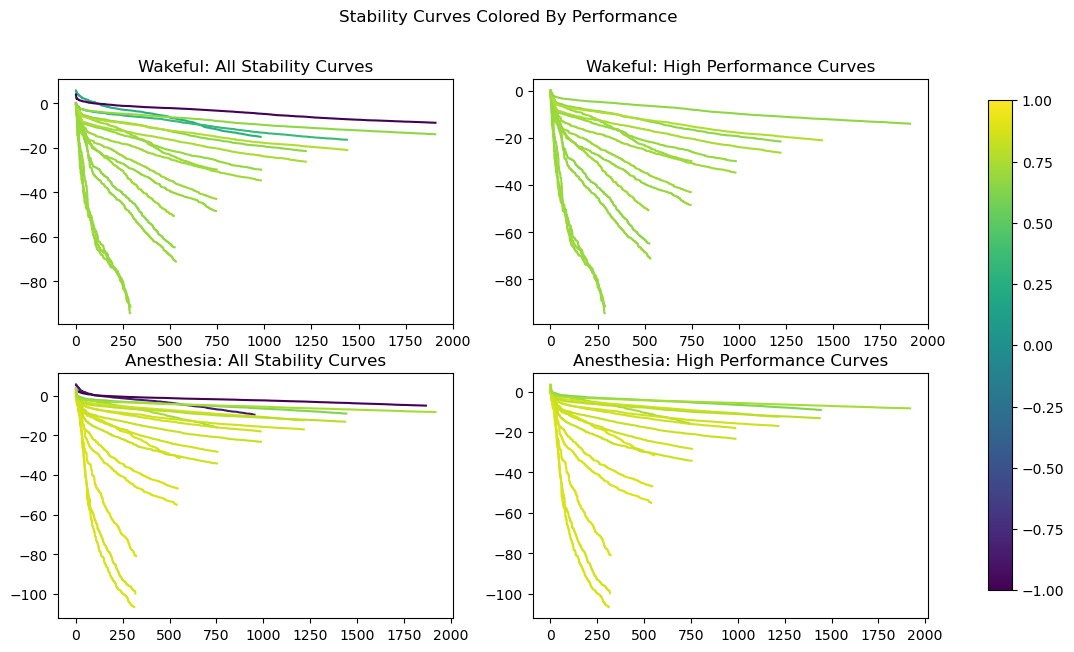

In [102]:
cmap = get_cmap('viridis')
norm = Normalize(vmin=-1, vmax=1)
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
for i, window in enumerate(window_vals):
    for j, p in enumerate(p_vals):
        rows = wake_ret[np.logical_and(wake_ret.window == window, wake_ret.p == p)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()
        if len(rows) >0:
            wake_curve = rows[0]
            anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.window==window, anesthesia_ret.p == p)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
#         anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
            axs[0, 0].plot(wake_curve, c=cmap(norm(wake_ip[j, i])))
            if wake_ip[j, i] > 0.6:
                axs[0, 1].plot(wake_curve, c=cmap(norm(wake_ip[j, i])))
                
            axs[1, 0].plot(anesthesia_curve, c=cmap(norm(anesthesia_ip[j, i])))
            if anesthesia_ip[j, i] > 0.6:
                axs[1, 1].plot(anesthesia_curve, c=cmap(norm(anesthesia_ip[j, i])))

axs[0, 0].set_title('Wakeful: All Stability Curves')
axs[0, 1].set_title('Wakeful: High Performance Curves')
axs[1, 0].set_title('Anesthesia: All Stability Curves')
axs[1, 1].set_title('Anesthesia: High Performance Curves')
fig.suptitle('Stability Curves Colored By Performance')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(ScalarMappable(norm, cmap), cax=cbar_ax)
plt.show()

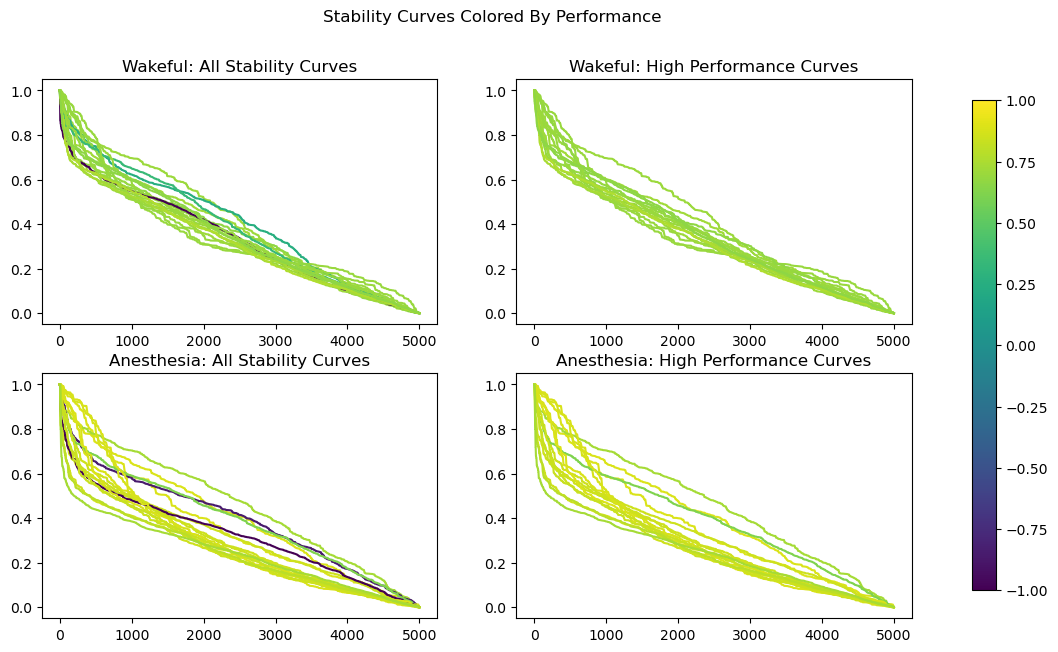

In [105]:
cmap = get_cmap('viridis')
norm = Normalize(vmin=-1, vmax=1)
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
full_length = 5000
for i, window in enumerate(window_vals):
    for j, p in enumerate(p_vals):
        rows = wake_ret[np.logical_and(wake_ret.window == window, wake_ret.p == p)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()
        if len(rows) >0:
            wake_curve = rows[0]
            anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.window==window, anesthesia_ret.p == p)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
#         anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
            
            wake_curve = (wake_curve - wake_curve.min())/(wake_curve.max() - wake_curve.min())
            anesthesia_curve = (anesthesia_curve - anesthesia_curve.min())/(anesthesia_curve.max() - anesthesia_curve.min())
            
            wake_curve = np.interp(np.arange(full_length), np.linspace(0, full_length - 1, len(wake_curve)), wake_curve)
            anesthesia_curve = np.interp(np.arange(full_length), np.linspace(0, full_length - 1, len(anesthesia_curve)), anesthesia_curve)
            
            axs[0, 0].plot(wake_curve, c=cmap(norm(wake_ip[j, i])))
        
            if wake_ip[j, i] > 0.6:
                axs[0, 1].plot(wake_curve, c=cmap(norm(wake_ip[j, i])))
                
            axs[1, 0].plot(anesthesia_curve, c=cmap(norm(anesthesia_ip[j, i])))
            if anesthesia_ip[j, i] > 0.6:
                axs[1, 1].plot(anesthesia_curve, c=cmap(norm(anesthesia_ip[j, i])))

axs[0, 0].set_title('Wakeful: All Stability Curves')
axs[0, 1].set_title('Wakeful: High Performance Curves')
axs[1, 0].set_title('Anesthesia: All Stability Curves')
axs[1, 1].set_title('Anesthesia: High Performance Curves')
fig.suptitle('Stability Curves Colored By Performance')
                
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(ScalarMappable(norm, cmap), cax=cbar_ax)
plt.show()

In [114]:
cumulative_explained = torch.cumsum(delase_wake.S**2/((delase_wake.S**2).sum()), 0)

In [155]:
explained_variance = 0.99

In [156]:
exp_variance_inds = delase_wake.S**2/((delase_wake.S**2).sum())

In [157]:
cumulative_explained = torch.cumsum(exp_variance_inds, 0)
r = int(torch.argmax((cumulative_explained > explained_variance).type(torch.int)).cpu().numpy())
r

1078

In [163]:
cumulative_explained = np.cumsum(exp_variance_inds.cpu().numpy(), 0)
r = int(np.argmax((cumulative_explained > explained_variance)))
r

1078

In [158]:
delase_wake.S[r]

tensor(1.4346, device='cuda:0')

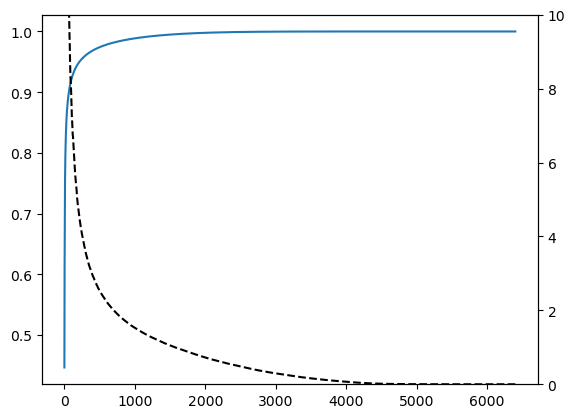

In [162]:
plt.plot(cumulative_explained.cpu())
ax2 = plt.gca().twinx()
ax2.plot(delase_wake.S.cpu(), linestyle='--', c='k')
ax2.set_ylim([0, 10])
plt.show()

In [164]:
delase_wake.V[:, :r].shape

torch.Size([14901, 1078])

In [169]:
delase_wake.V_coord.shape

torch.Size([14901, 2981])

In [168]:
torch.hstack([delase_wake.V_coord, torch.ones(delase_wake.V_coord.shape[0], 1).cuda()]).shape

torch.Size([14901, 2982])

In [171]:
np.hstack([delase_wake.V_coord.cpu().numpy(), np.ones((delase_wake.V_coord.shape[0], 1))]).shape

(14901, 2982)